### About PCA

PCA simplifies the complexity of high-dimensional data while keeping its trends and patterns. It does this by transforming the data into a new coordinate system, where the greatest variance by any projection of the data comes to lie on the first coordinate (PCA1), the second greatest variance on the second coordinate, and so on.

By comparing the PCA results of proteomics, metabolomics, and lipidomics data, we can identify if one type of omics data diverges significantly from the others. What is more, we can see the impact of Pareto scaling on the PCA results.

In [1]:
from methods.helper import *
import seaborn as sns
from sklearn.decomposition import PCA
import cv2
import matplotlib.pyplot as plt
import numpy as np

C:\Users\mjgoj\miniconda3\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [2]:
# Palettes for consistent plotting

TWO_CLASS_PALETTE = {
    0: "deepskyblue",
    1: "tomato"
}

THREE_CLASS_PALETTE = {
    0: "deepskyblue",
    1: "lightsalmon",
    2: "tomato"
}

Loading the data including scaled and unscaled metabolomics and proteomics datasets

In [3]:
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xls"
xls = pd.ExcelFile(path)

metabolomics = pd.read_excel(xls, "Metabolomics")
lipidomics = pd.read_excel(xls, "Lipidomics")
proteomics = pd.read_excel(xls, "Proteomics")
metabolomics_pareto = pd.read_excel(xls, "Pareto Metabolomics")
proteomics_pareto = pd.read_excel(xls, "Pareto Proteomics")

# Preliminary
Investigation of the distribution of the data before performing PCA.

In [4]:
# Load the binary dataset
X_train, X_test, Y_train, y_test = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=2)

# Load the three-class dataset
X_train_3, X_test_3, Y_train_3, y_test_3 = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=3)

In [5]:
labels_3class = {0: 'Stable', 1: 'Slow Decliner', 2: 'Fast Decliner'}
labels_2class = {0: 'Stable', 1: 'Decliner'}

# Map the labels to the classes
Y_train_labels_3class = Y_train_3.map(labels_3class)
y_test_labels_3class = y_test_3.map(labels_3class)
Y_train_count_3class = Y_train_labels_3class.value_counts()
y_test_count_3class = y_test_labels_3class.value_counts()

# Map the labels to the classes
Y_train_labels_2class = Y_train.map(labels_2class)
y_test_labels_2class = y_test.map(labels_2class)
Y_train_count_2class = Y_train_labels_2class.value_counts()
y_test_count_2class = y_test_labels_2class.value_counts()

# Add the count of each class on top of the bars
y_lim = max(
    Y_train_count_3class.max(), y_test_count_3class.max(), 
    Y_train_count_2class.max(), y_test_count_2class.max()) + 10

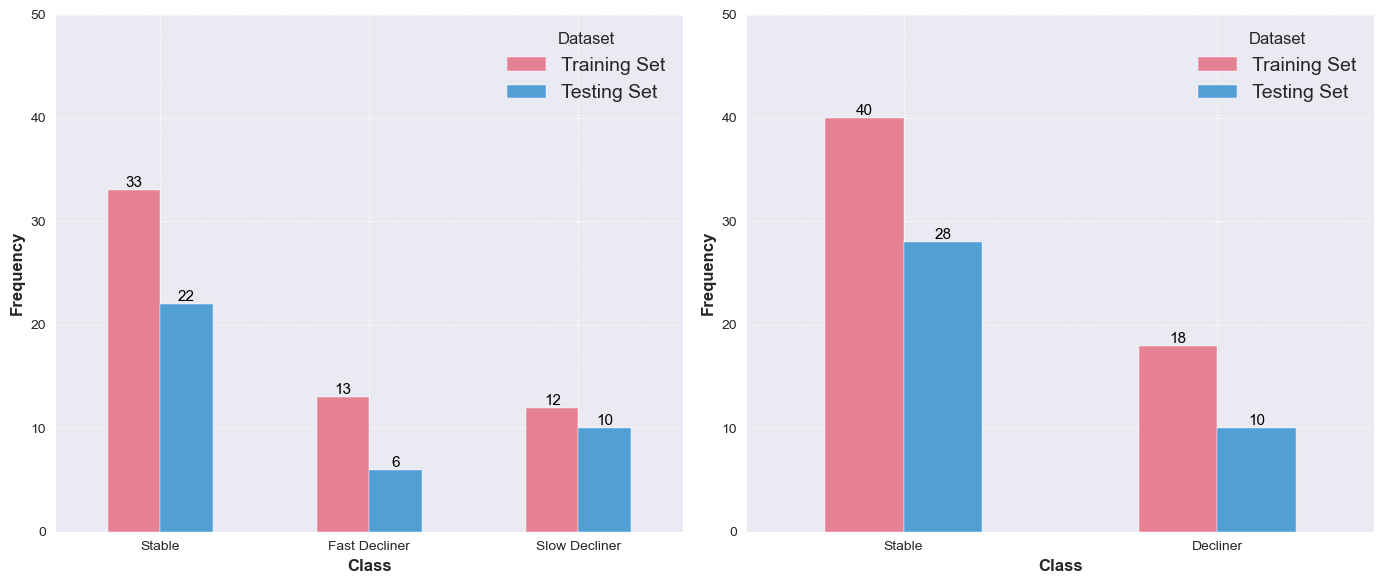

In [6]:
# Create a DataFrame for the distribution of the classes in the training and testing sets
df_3class = pd.concat(
    [Y_train_count_3class, y_test_count_3class], axis=1, 
    keys=['Training Set', 'Testing Set']).reset_index().rename(columns={'index': 'Class'})

# Create a DataFrame for the distribution of the classes in the training and testing sets
df_2class = pd.concat(
    [Y_train_count_2class, y_test_count_2class], axis=1, 
    keys=['Training Set', 'Testing Set']).reset_index().rename(columns={'index': 'Class'})

# Create a plot of the distribution of the classes in the training set
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plt.style.use("seaborn-v0_8")
plt.rcParams.update({'font.size': 12})

colors = sns.color_palette("husl", 3)
palette = [colors[0], colors[2]]

# Grouped bar plot for 3 class classification
sns.barplot(
    data=df_3class.melt(id_vars='Class'), x='Class', y='value', 
    hue='variable', ax=axs[0], palette=palette, width=0.5
)
axs[0].set_ylabel("Frequency", fontsize=12, weight='bold')
axs[0].set_ylim(0, y_lim)
axs[0].legend(title='Dataset', prop={'size': 14})
axs[0].grid(True, linestyle='--', linewidth=0.5)
axs[0].set_xlabel('Class', fontsize=12, weight='bold')

# Grouped bar plot for 2 class classification
sns.barplot(
    data=df_2class.melt(id_vars='Class'), x='Class', y='value', 
    hue='variable', ax=axs[1], palette=palette, width=0.5
)
axs[1].set_ylabel("Frequency",  fontsize=12, weight='bold')
axs[1].set_ylim(0, y_lim)
axs[1].legend(title='Dataset', prop={'size': 14})
axs[1].grid(True, linestyle='--', linewidth=0.5)
axs[1].set_xlabel('Class', fontsize=12, weight='bold')

# Add the count of each class on top of the bars
for ax in axs.flat:
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(
                f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()

### PCA for each dataset separately

First, we will perform PCA on each dataset separately to see the variance explained by each principal component and the score plot.

In [7]:
def plot_variance_explained(pca_, omics_type):
    """
    Create a variance explained bar plot for the PCA model
    :param pca_: PCA model
    :param omics_type: Type of omics data
    """
    explained_variance = pca_.explained_variance_ratio_
    plt.figure(figsize=(6, 3))
    sns.barplot(
        x=range(1, len(explained_variance) + 1), 
        y=explained_variance, 
        palette='crest', hue=explained_variance, legend=False)
    plt.title('Variance explained by each principal component (' + omics_type + ')')
    plt.grid()
    plt.show()

In [8]:
def plot_scores(principal_components, omics_type, class_labels=None):
    """
    Create a score plot for the PCA model
    :param principal_components: Principal components of the data from PCA
    :param omics_type: Type of omics data
    """
    scores_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    plt.figure(figsize=(6, 4))
    if class_labels is not None:
        scores_df['label'] = class_labels
        palette = TWO_CLASS_PALETTE if len(np.unique(class_labels)) == 2 else THREE_CLASS_PALETTE
        sns.scatterplot(
            x='PC1', y='PC2', 
            data=scores_df, hue='label', palette=palette)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        sns.scatterplot(
            x='PC1', y='PC2', 
            data=scores_df, legend=False)
        plt.title('PCA Score Plot (' + omics_type + ')')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Score Plot (' + omics_type + ')')
    plt.show()

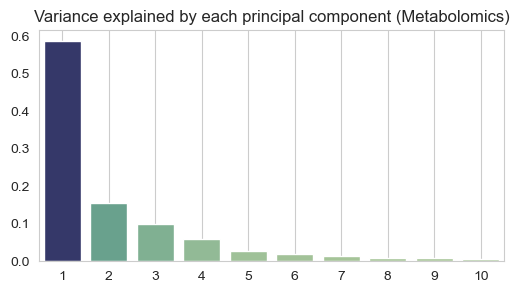

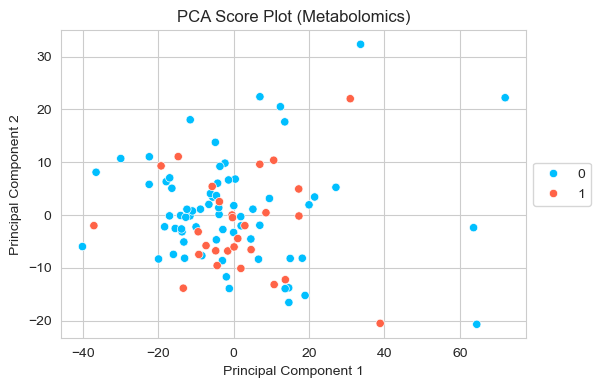

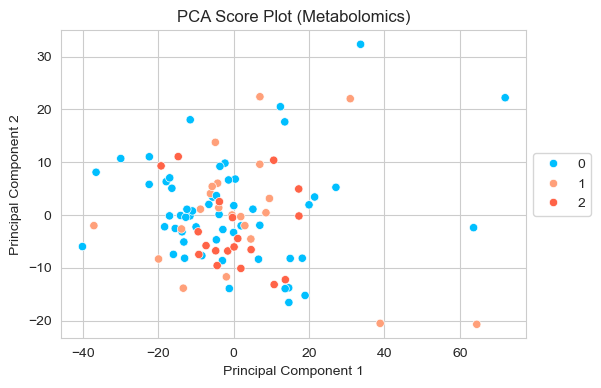

In [144]:
# Metabolomics
pca_metabolites = PCA(n_components=10)
# Fit the model with X and apply the dimensionality reduction on X
principal_components_met = pca_metabolites.fit_transform(
    metabolomics[metabolomics.columns[3:]])
plot_variance_explained(pca_metabolites, omics_type="Metabolomics")
plot_scores(
    principal_components_met[:, :2], "Metabolomics", 
    class_labels=metabolomics[['TwoClass']])
plot_scores(
    principal_components_met[:, :2], "Metabolomics", 
    class_labels=metabolomics[['ThreeClass']])

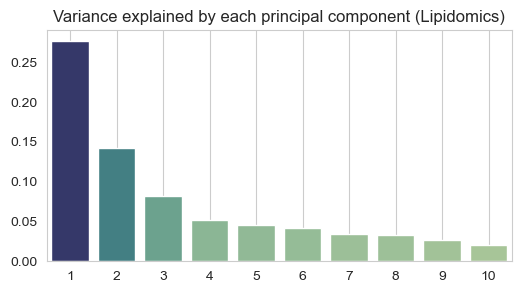

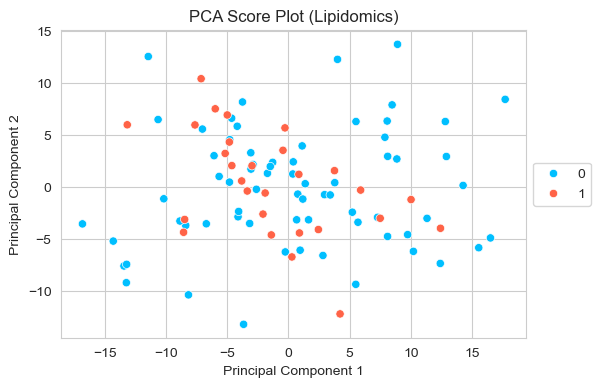

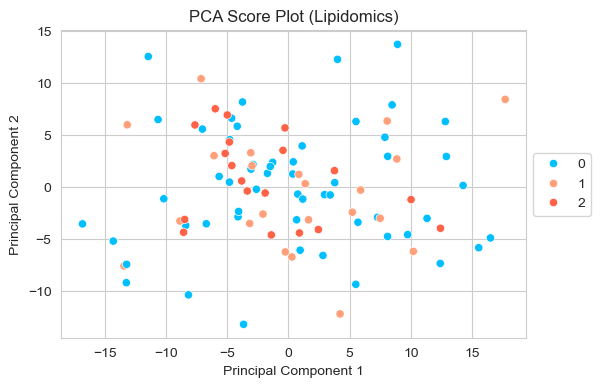

In [145]:
# Lipidomics
pca_lipids = PCA(n_components=10)
# Fit the model with X and apply the dimensionality reduction on X
principal_components_lip = pca_lipids.fit_transform(
    lipidomics[lipidomics.columns[3:]])
plot_variance_explained(pca_lipids, omics_type="Lipidomics")
plot_scores(
    principal_components_lip[:, :2], "Lipidomics", 
    class_labels=lipidomics[['TwoClass']])
plot_scores(
    principal_components_lip[:, :2], "Lipidomics", 
    class_labels=lipidomics[['ThreeClass']])

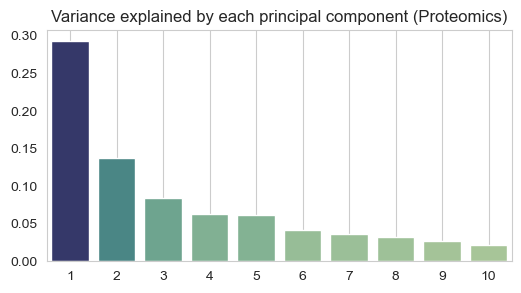

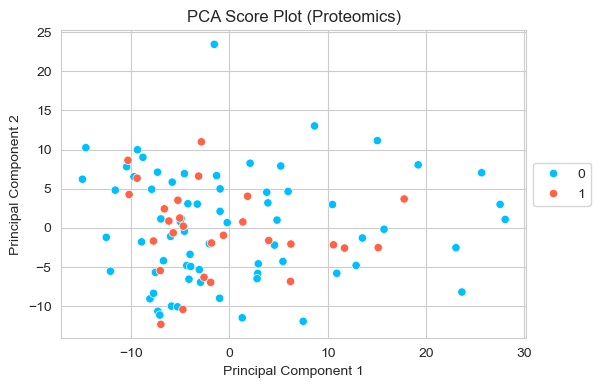

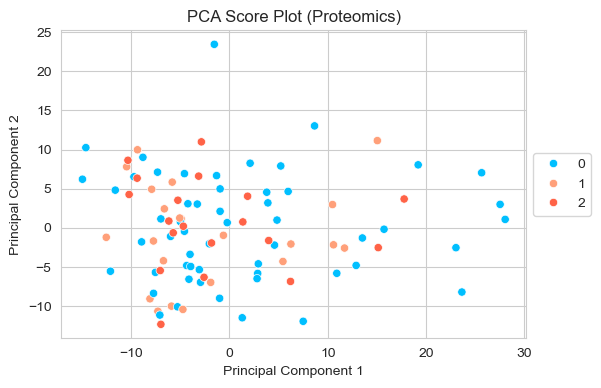

In [146]:
# Proteomics
pca_proteins = PCA(n_components=10)
# Fit the model with X and apply the dimensionality reduction on X
principal_components_prot = pca_proteins.fit_transform(
    proteomics[proteomics.columns[3:]])
plot_variance_explained(pca_proteins, omics_type="Proteomics")
plot_scores(
    principal_components_prot[:, :2], "Proteomics", 
    class_labels=proteomics[['TwoClass']])
plot_scores(
    principal_components_prot[:, :2], "Proteomics", 
    class_labels=proteomics[['ThreeClass']])

### PCA for all the datasets combined

Now we will combine all the datasets and perform PCA. First I will create a loadings plot to see the contribution of each feature to the principal components and from which dataset they come from.

In [147]:
def loadings_plot(data_, loadings, features_, num_features=None, save_path=None):
    """
    Create a loadings plot for the PCA model.
    :param data_: Combined data used to fit the PCA model
    :param loadings: PCA loadings
    :param features_: labels for the data type of the features
    :param num_features: Number of most contributing features to display on the loadings plot
    (default is None, which will display all features)
    :param save_path: Path to save the plot (default is None)
    """
    plt.figure(figsize=(10, 8))
    colors_ = sns.color_palette("husl", 3)
    
    # Map the colors to the omics types
    color_map = {feature: colors_[idx] for idx, feature_set in enumerate(features_) for feature in feature_set}
    
    # For PC1 and PC2
    for pc in range(2):
        if num_features is not None:
            sorted_idx = np.argsort(np.abs(loadings[:, pc]))[::-1]
            top_features = sorted_idx[:num_features]
        else:
            top_features = range(len(loadings))
        for feature in top_features:
            feature_name = data_.columns[feature]
            color = color_map.get(feature_name, 'black')
            plt.arrow(
                0, 0, loadings[feature, 0] * 5, 
                loadings[feature, 1] * 5, color=color, alpha=0.65)
    
    # Add legend for the omics types
    labels = ['Metabolomics', 'Lipidomics', 'Proteomics']
    for idx, label in enumerate(labels):
        plt.scatter([], [], color=colors_[idx], label=label)
    
    plt.legend(
        scatterpoints=1, frameon=True, labelspacing=1, 
        title='Omics type', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    title = 'PCA Loadings Plot'
    if num_features is not None:
        title += f' (Top {num_features} features)'
    plt.title(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [148]:
def get_loadings(data_):
    """
    Get the loadings of the PCA model
    :param data_: Combined data used to fit the PCA model
    """
    pca_ = PCA(n_components=10)
    # Fit the model with X and apply the dimensionality reduction on X
    pca_.fit_transform(data_)
    loadings = pca_.components_.T * np.sqrt(pca_.explained_variance_)
    return loadings

In [149]:
combined_data = pd.concat([
    metabolomics.iloc[:, 3:], 
    lipidomics.iloc[:, 3:], 
    proteomics.iloc[:, 3:]], axis=1)

loadings_ = get_loadings(combined_data)

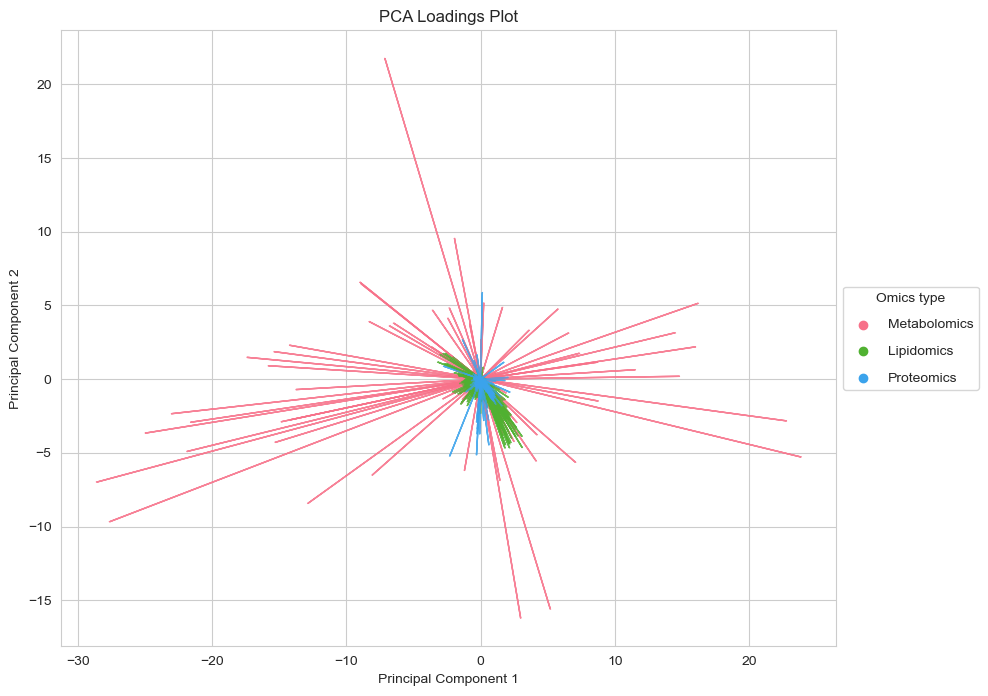

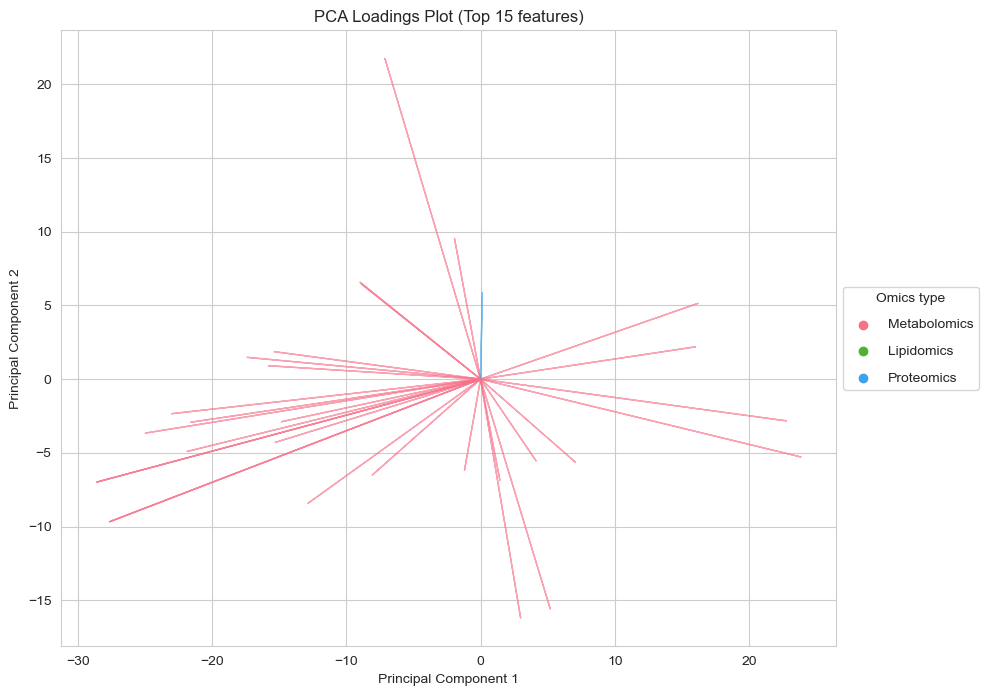

In [150]:
features_ = [
    list(metabolomics.columns[3:]), 
    list(lipidomics.columns[3:]), 
    list(proteomics.columns[3:])]
loadings_plot(
    combined_data, loadings_, features_,
    save_path="C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/images/loadings_before.png"
)
loadings_plot(
    combined_data, loadings_, features_, 15)

### Transposed Scores Plot
Now we will create a transposed scores plot to see the separation of the samples based on the omics type. The aim is to see if the samples from different omics types are well separated.

In [151]:
def perform_pca(data, n_components=2):
    """
    Perform PCA on the given data.
    :param data: DataFrame to perform PCA on
    :param n_components: Number of principal components to compute
    :return: Principal components
    """
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)
    return principal_components

def plot_scores(principal_components, labels, save_path=None):
    """
    Create a PCA scores plot.
    :param principal_components: PCA-transformed data
    :param labels: Labels for the samples
    :param save_path: Path to save the plot (default is None)
    """
    scores_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
    scores_df['label'] = labels
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', data=scores_df, hue='label', palette="magma", alpha=0.65)
    plt.title('PCA Score Plot')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Omics type', loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, labelspacing=1)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def transposed_scores_plot(data_, labels_, save_path=None):
    """
    Combine the data, perform PCA, and create a PCA scores plot.
    :param data_: DataFrame to perform PCA on
    :param labels_: Labels for the samples
    :param save_path: Path to save the plot (default is None)
    """
    principal_components = perform_pca(data_)
    plot_scores(principal_components, labels_, save_path)

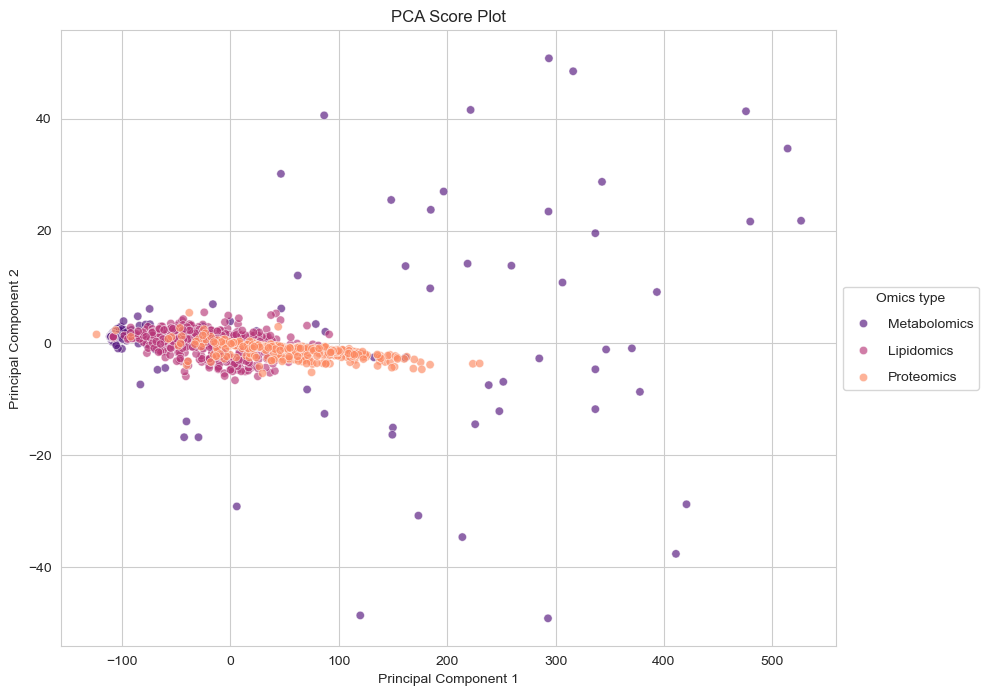

In [152]:
combined_data_T = combined_data.T
labels = (["Metabolomics"] * (metabolomics.shape[1] - 3) + 
              ["Lipidomics"] * (lipidomics.shape[1] - 3) + 
              ["Proteomics"] * (proteomics.shape[1] - 3))
transposed_scores_plot(
    combined_data_T, labels, 
    save_path="C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/images/scores_plot_before_normalization.png")

### Pareto Scaled Metabolomics included
Now we will include the pareto scaled metabolomics data and see if the PCA results change.

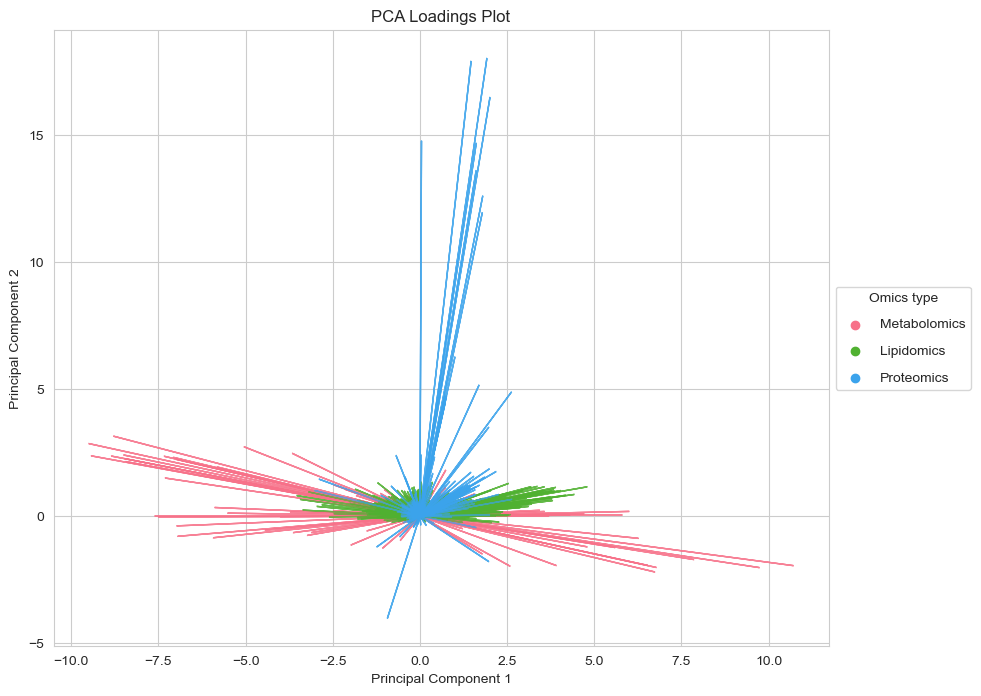

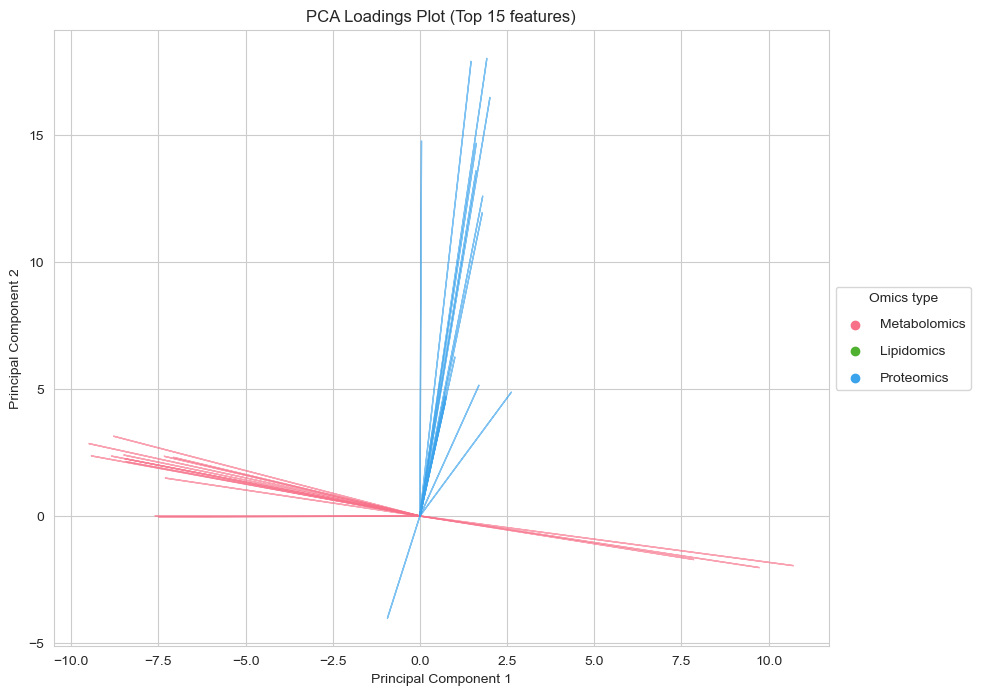

In [153]:
combined_data = pd.concat([
    metabolomics_pareto.iloc[:, 3:], 
    lipidomics.iloc[:, 3:], 
    proteomics.iloc[:, 3:]], axis=1)

loadings = get_loadings(combined_data)

loadings_plot(combined_data, loadings, features_)
loadings_plot(
    combined_data, loadings, features_, 15)

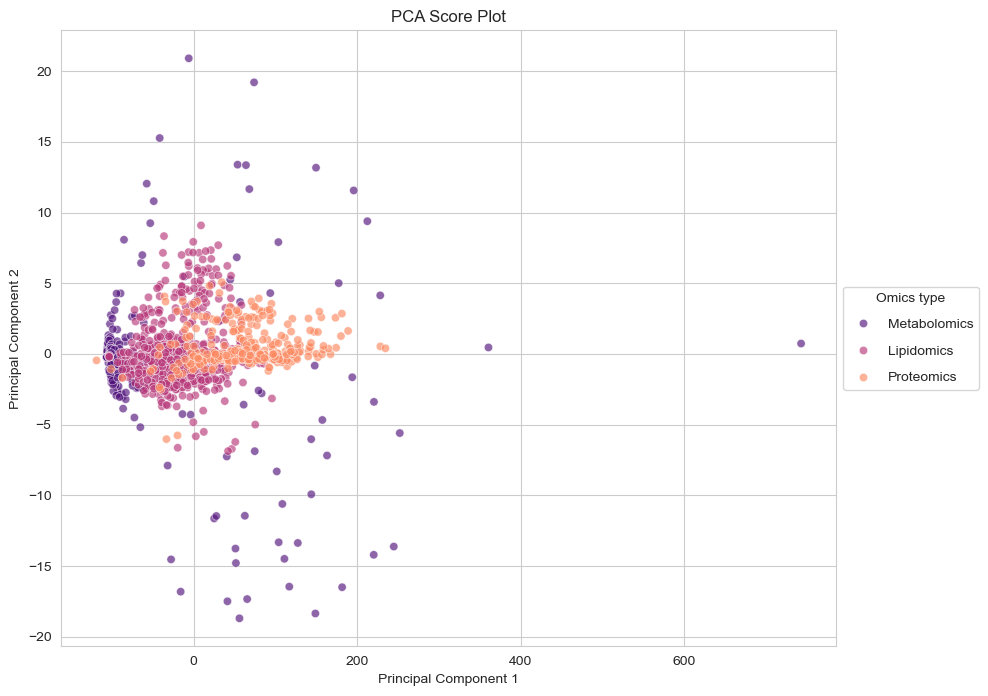

In [154]:
combined_data_T = combined_data.T
transposed_scores_plot(combined_data_T, labels)

### Pareto Scaled Metabolomics and Proteomics included
Now we will include the pareto scaled metabolomics and proteomics data and see if the PCA results change.

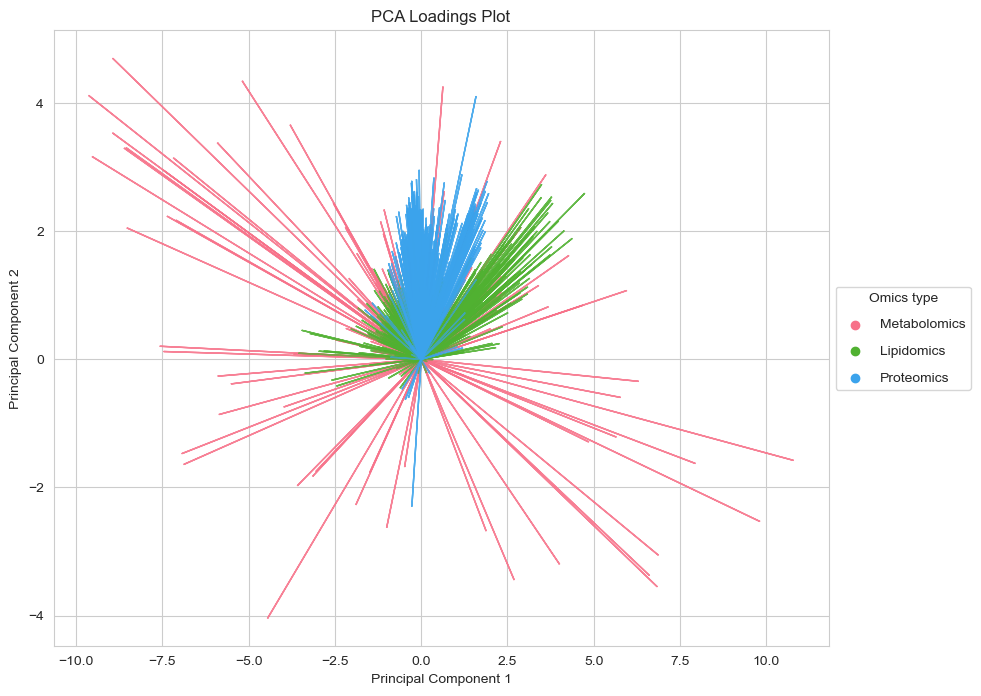

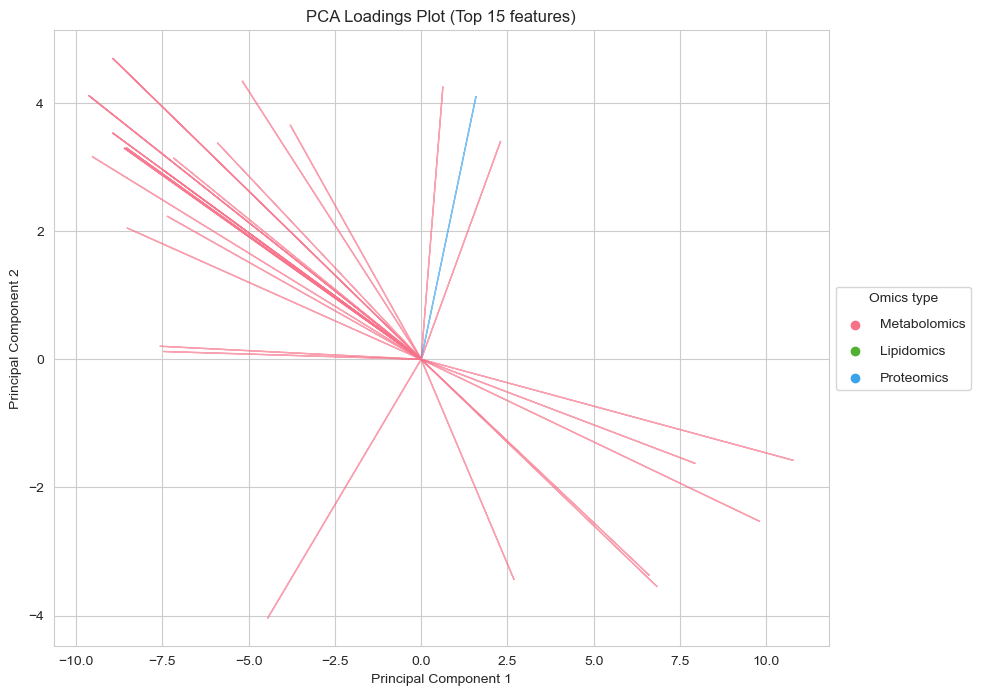

In [155]:
combined_data = pd.concat([
    metabolomics_pareto.iloc[:, 3:], 
    lipidomics.iloc[:, 3:], 
    proteomics_pareto.iloc[:, 3:]], axis=1)

loadings = get_loadings(combined_data)

loadings_plot(
    combined_data, loadings, features_,
    save_path="C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/images/loadings_after.png")
loadings_plot(
    combined_data, loadings, features_, 15)

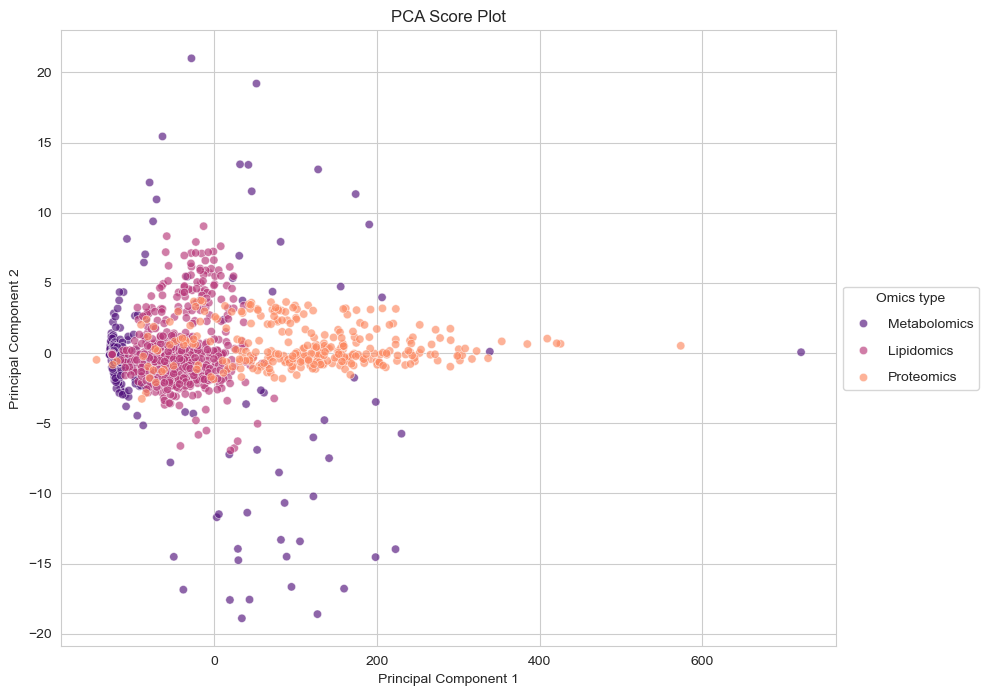

In [156]:
combined_data_T = combined_data.T
transposed_scores_plot(combined_data_T, labels, "C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/images/scores_plot_after_normalization.png")

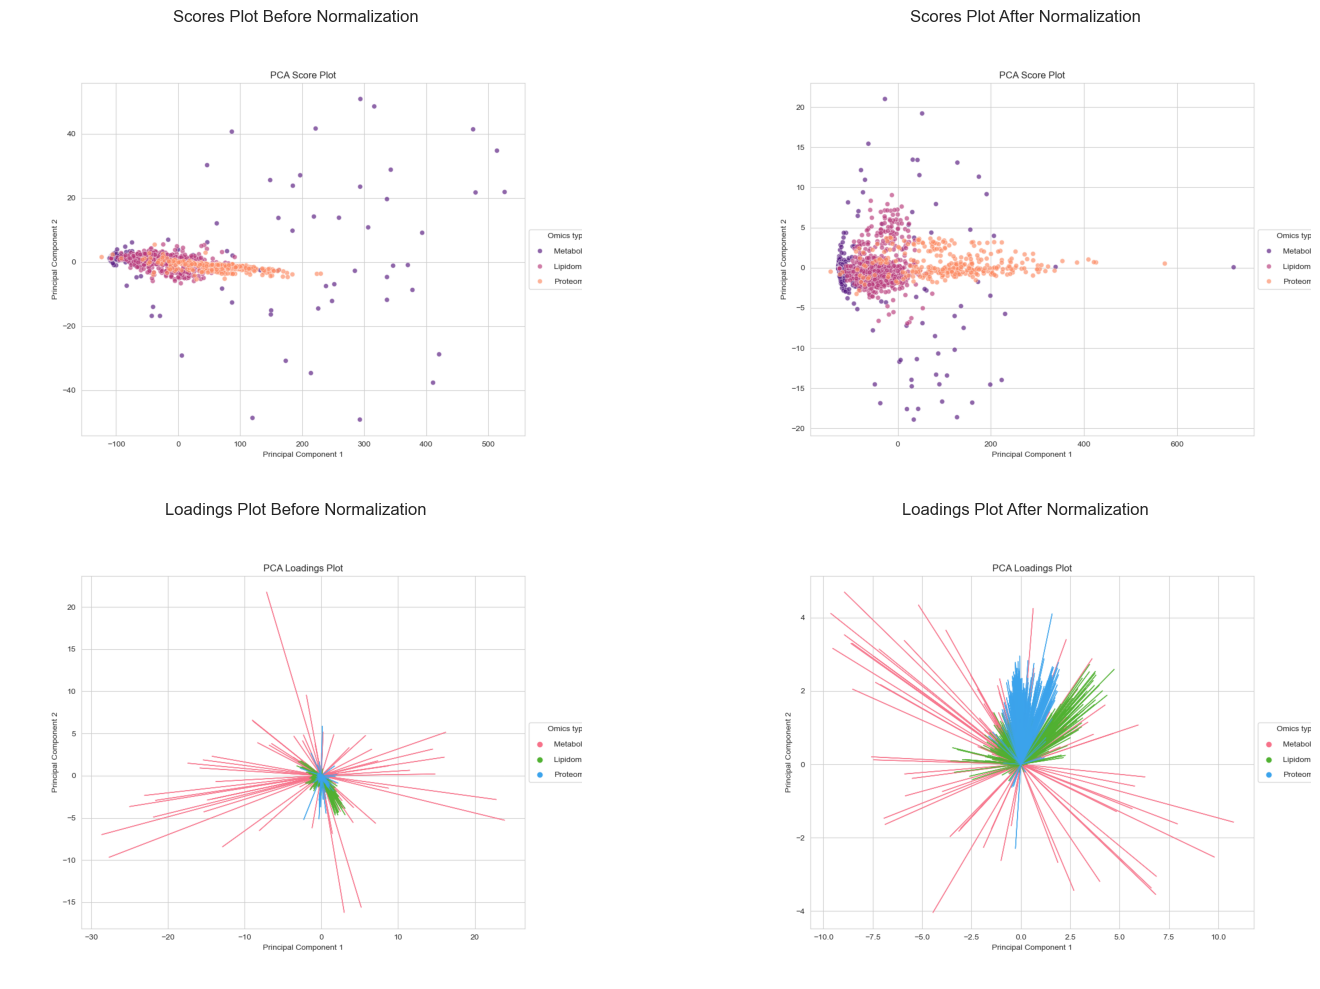

In [157]:
images = [
    cv2.imread("C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/images/scores_plot_before_normalization.png"),
    cv2.imread("C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/images/scores_plot_after_normalization.png"),
    cv2.imread("C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/images/loadings_before.png"),
    cv2.imread("C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/images/loadings_after.png")
]
titles = [
    'Scores Plot Before Normalization', 'Scores Plot After Normalization',
    'Loadings Plot Before Normalization', 'Loadings Plot After Normalization'
]

# Convert BGR images to RGB
images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

# Show them side by side
plt.figure(figsize=(16, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()
